In [21]:
# Particle Tracking Code Part One

We'll use the *widely* used particle tracking code that's based on code developed by [John Crocker](http://crocker.seas.upenn.edu/). Originally, that code was developed in IDL. But others have rewritten it in Matlab (for example, [here](http://site.physics.georgetown.edu/matlab/)) and in Python. We'll use the Python code which is provided by [Maria Kilfoil](http://people.umass.edu/kilfoil/). 

The Python particle tracking code we'll use was grabbed from [here](http://people.umass.edu/kilfoil/tools.php). But I've made some slight changes (necessary for how we'll load the images and given the updated version of Python we're using). 

In [3]:
#importing the required modules
import numpy as np #Numerical Python
import scipy #Scientific Python

%matplotlib inline

import mpld3 #For making nice looking plots
#If mpld3 is not available, install with conda (run "conda install mpld3" in Anaconda
# command prompt)

mpld3.enable_notebook()
import matplotlib
from matplotlib import pylab

#For making interactive user interfaces (buttons and sliders and such)
import ipywidgets as widgets
from ipywidgets import Layout, interact, fixed

#Loading the particle tracking software
import sys
##MAC
sys.path.append("..//track") #Locate code
##PC
# sys.path.append("..\\track")
import mpretrack #The file mpretrack.py and trackmem.py should be in the location above
import trackmem
import bpass
import tiff_file #Ignore any warnings importing this may cause
import pickle

..//track\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
..//track\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
..//track\tiff_file.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


In [4]:
#Now let's locate the data
##MAC 
#data_directory = "//Volumes//USB DISK//60fps_2//" #Notice the double slashes!

##PC
data_directory = "Z:\\ChristelleSummer2018\\Data\\BeadsInConditions\\Actin\\2018_07_13\\40\\2018_07_13_Actin40fps_1\\"
#data_file = "Substack (1-500).tif"
data_file = data_directory.split('\\')[-2]+"_MMStack_Pos0.ome.tif"
frame_rate = 40.0

### Let's inspect the data

We'll show the first frame of the movie we'll use. 
Then we'll show what that frame looks like when we filter it using a bandpass filter.

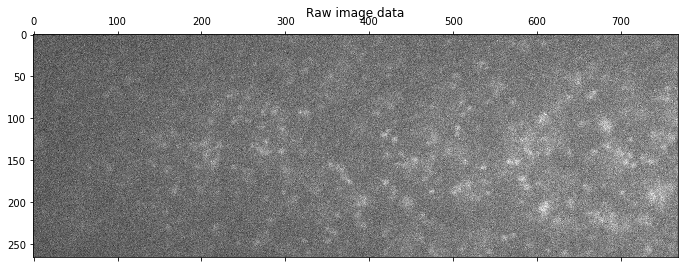

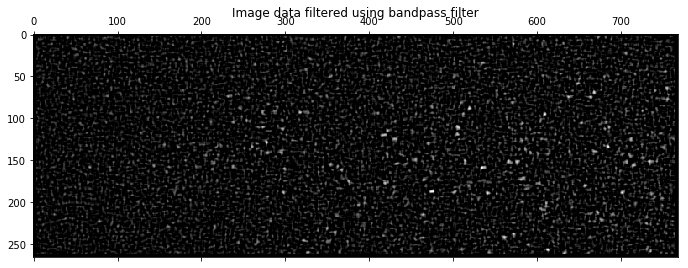

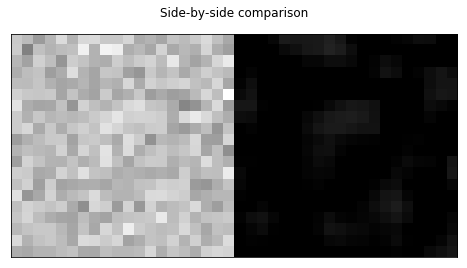

In [5]:
%matplotlib inline

#We use the "tiff_file" module to deal with image data in tif formats.
#The function 'imread' reads in the image. We can either read in the whole entire
#  movie or just read in a specific frame. Here, we are reading in only the first 
#  frame. We do this by setting the optional paratmer 'key' equal to 0. 
frame1_image = tiff_file.imread(data_directory+data_file,key=0)

pylab.matshow(frame1_image, cmap=matplotlib.cm.gray) #'cmap' is the colormap used
pylab.title("Raw image data")

#Let's try filtering the data with a bandpass filter. This filter is used when
#  identifying features in the image. 
bpass_image = bpass.bpass(frame1_image,1,3)

pylab.matshow(bpass_image, cmap=matplotlib.cm.gray)
pylab.title("Image data filtered using bandpass filter")

#We'll show a side-by-side comparison of non-filtered and filtered images.
# Using the numpy function 'hstack' to combine two arrays horizontally
pylab.matshow(np.hstack((frame1_image[18:38,42:62], bpass_image[18:38,42:62])), cmap=matplotlib.cm.gray, interpolation='nearest')
pylab.xticks([]); pylab.yticks([]) #This removes the labeling of the axes values
pylab.title('Side-by-side comparison');

In [6]:
#Use the function 'test' in mpretrack to find good set of parameters

###############################################################################
# Options from mpretrack:
#    barI: minimum integrated intensity
#    barRg: maximum radius of gyration squared (in pixel squared)
#    barCc: minimum eccentricity" accepted
#    IdivRg: minimum ratio of of integrated intensity to radius of gyr sqrd
#    Imin: minimum intensity of local max -- set to 0 to use default "top 30%"
#    masscut: threshold for integrated intesnity of features before refinement
#    field: 2 for full frame (0 or 1 if interlaced video)
###############################################################################

frame_num = 0 #We'll use the first frame
feature_size = 7
%matplotlib inline
mt, mrej = mpretrack.test(data_directory,data_file,frame_num,feature_size,
                          masscut = 500, Imin=400, barI =600, barRg = 15,
                          barCc = 10, IdivRg=1.0, verbose=False, bandpass='bp')


-----------TEST-----------


MemoryError: 

Did that look okay? You should see a figure appear with green dots where the program found particles. Red dots indicate that particles were identified but then discarded due to not meeting the thresholds (like being below the minimum integrated intensity or exceeding the maximum radius of gyration).

Now we'll run the feature-finding algorithm with the paramters we found on *all* frames.

In [ ]:
feature_size = 7
num_frames = 5000 #number of frames to find particles

#Same parameters used as in "test".
#NOTE: I set verbose=False here so it doesn't print out too much 
#But you should set verbose=True. 
#It will then print out how many particles found in each frame.
mt = mpretrack.run(data_directory,data_file,num_frames,feature_size,
                   masscut = 500, Imin=400, barI = 600, barRg = 15,
                   barCc = 10, IdivRg=1.0, verbose=False, bandpass='bp')
pickle.dump(mt, open(data_directory+ '\\mt.p', 'wb'))

Frame 0
Frame 50
Frame 100
Frame 150
Frame 200
Frame 250
Frame 300
Frame 350
Frame 400
Frame 450
Frame 500
Frame 550
Frame 600
Frame 650
Frame 700
Frame 750
Frame 800
Frame 850
Frame 900
Frame 950
Frame 1000
Frame 1050
Frame 1100
Frame 1150
Frame 1200
Frame 1250


In each frame, the code has identified particles (i.e., features). Now we have to link them together into "tracks."


In [9]:
### Tracking with fancytrack:
num_dimensions = 2 #We take 2-dimensional images
max_displacement = 2 #3 #Maximum displacement between consecutive frames to count as same particle
goodenough = 20 #Minimum length for trajectory
memory = 1 #how many consecutive frames a feature is allowed to skip. 
tracks = trackmem.trackmem(mt, max_displacement, num_dimensions, goodenough, memory)

What's in <code>tracks</code>?
+ <code>tracks[:,0]</code> is the *x*-coordinate of particle (in terms of pixel)
+ <code>tracks[:,1]</code> is the *y*-coordinate
+ <code>tracks[:,2]</code> is the integrated brightness of found features
+ <code>tracks[:,3]</code> is the square of the radius of gyration
+ <code>tracks[:,4]</code> is the eccentricity (zero for circularly symmetric features)
+ <code>tracks[:,5]</code> is the frame number
+ <code>tracks[:,6]</code> is the time
+ <code>tracks[:,7]</code> is the trajectory ID number

Let's look at how many trajectories we've found, what the length of some of these trajectories are and what they look like superimposed on an image of the beads.

In [10]:
#The last element in the each "track" is the track ID number. It starts at one. 
# So finding the maximum of the track ID number will tell us how many tracks
# there are. 
print "Number of trajectories: %i" % tracks[:,7].max()

Number of trajectories: 4076


In [11]:
#Just to get a sense of the length of the trajectories.
#Printing the lenghts by funding all instances where the track ID
#  number is 1, 2, 3. 

print "Length of 1st trajectory: %i" % np.sum(tracks[:,7]==1)
if tracks[:,7].max()>1: #this checks to make sure there is a track ID 2
    print "Length of 2nd trajectory: %i" % np.sum(tracks[:,7]==2)
if tracks[:,7].max()>2:
    print "Length of 3rd trajectory: %i" % np.sum(tracks[:,7]==3)

Length of 1st trajectory: 22
Length of 2nd trajectory: 44
Length of 3rd trajectory: 43


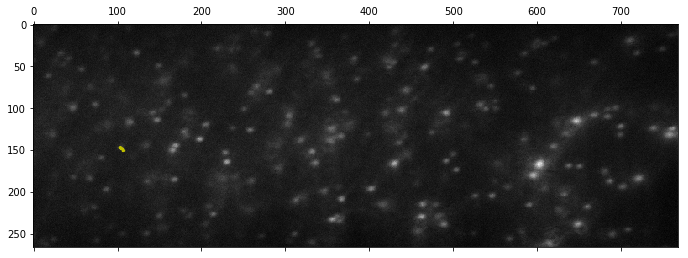

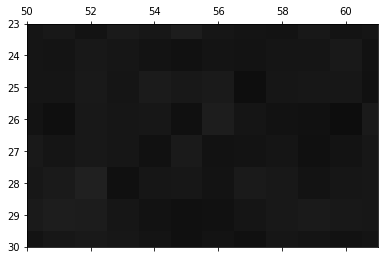

In [12]:
%matplotlib inline
mpld3.disable_notebook() #with mpld3, the zoom function for inline plots is available

frame1_image = tiff_file.imread(data_directory+data_file,key=0) #read in first frame

#Sometimes images need to be flipped upside down. If that's the case, change False to True
if False:
    pylab.matshow(np.flipud(frame1_image), cmap=matplotlib.cm.gray) #not sure why I need the flipud but seem to
else:
    pylab.matshow(frame1_image, cmap=matplotlib.cm.gray)

#Locate track ID 37 (that's just one I found that looks okay)
w = np.where(tracks[:,7]==37)
pylab.plot(tracks[w[0],0],tracks[w[0],1],'-y',lw=2)

#Show same thing but zoom in on the track
if False:
    pylab.matshow(np.flipud(frame1_image), cmap=matplotlib.cm.gray) #not sure why I need the flipud but seem to
else:
    pylab.matshow(frame1_image, cmap=matplotlib.cm.gray)
pylab.plot(tracks[w[0],0],tracks[w[0],1],'-y',lw=2)
pylab.xlim(50,61);
pylab.ylim(30,23);

In [13]:
track_IDs_Length = np.zeros((int(tracks[:,7].max()),2)) #Array of track ID numbers and length of those tracks
for i in range(1,int(tracks[:,7].max()+1)):
    w = np.where(tracks[:,7]==i)
    track_IDs_Length[i-1,0] = i
    track_IDs_Length[i-1,1] = len(w[0])
        

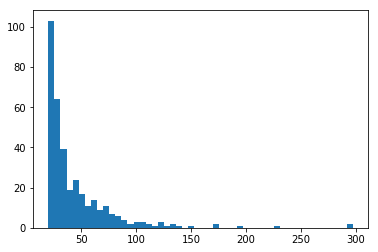

In [346]:
#pylab.hist(track_IDs_Length[:,1],bins=50);

# Finding the inital diffusion coefficient

In [14]:
total_sd = np.zeros((num_frames)) #total squared displacements
num_sd = np.zeros((num_frames)) #number of squared displacements
len_cutoff = 5


for i in range(0,len(track_IDs_Length)):
    if track_IDs_Length[i,1]>len_cutoff:
        #Find indices for a given track ID number
        w = np.where(tracks[:,7]==track_IDs_Length[i,0])
        frameIDs = tracks[w[0],5] ##finds the frame numbers for the specified trackID
        xys = tracks[w[0],0:2] #x- and y-positions
        
        
        
        #Loop over delay times
        for j in range(1,xys.shape[0]-1):
            xdiff = xys[j:,0]-xys[0:-1*(j),0] #Vector of displacment in x
            ydiff = xys[j:,1]-xys[0:-1*(j),1] #Vector of displacment in y
            squared_displacement = xdiff**2 + ydiff**2 #Squared displacemnt in x-y plane
            
            #Here, sum the squared displacments and keep track of how many
            # displacements when into the sum. This way we can find the average.
            total_sd[j-1] = total_sd[j-1] + squared_displacement.sum()
            num_sd[j-1] = num_sd[j-1] + len(squared_displacement)
    else:
        print "cutoff...", i


In [15]:
'\\'.join(data_directory.split("\\")[:-2])+'\\MSD\\msd1.p'

'Z:\\ChristelleSummer2018\\Data\\BeadsInConditions\\Dilute\\2018_07_05\\40\\MSD\\msd1.p'

In [16]:
pixel_size = 0.189 #Multiplying by 2 because image was 2x2 binned. This is for 40x on Motic. 

#You may need to adjust pixel size
w = np.where(num_sd==0)
msd = (total_sd[:w[0][0]]/num_sd[:w[0][0]]) * (pixel_size**2)
times= np.arange(1,len(msd)+1)/frame_rate



C:\Users\Student\Anaconda2\lib\site-packages\mpld3\mplexporter\exporter.py:179: UserWarning: Legend element <matplotlib.offsetbox.HPacker object at 0x000000000A515358> not impemented
  warnings.warn("Legend element %s not impemented" % child)


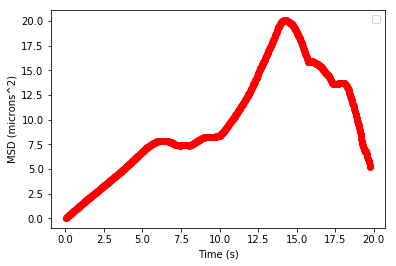

In [17]:
##Saves the msds as a python file to be used later and as a csv text file for ease of access
save_to = '\\'.join(data_directory.split("\\")[:-2])
pickle.dump(msd, open(save_to + '\\MSD\\msd3.p' , 'wb')) ##this will save to the 
#pickle.dump(times, open(save_to + '\\MSD\\times1.p' , 'wb'))
#np.savetxt(data_directory+'TimesMsd.txt',np.transpose((times,msd)),delimiter=',')
## pickle.dump(video_number, open(save_to + '\\'+'video_number.p', 'wb')) ##this will save to the fps folder and keep overwriting...

mpld3.enable_notebook()

# pylab.loglog(times5, msd5,'ro', alpha = .1) 
# pylab.plot(times10, msd10,'bo', alpha = .1)
# pylab.plot(times20, msd20,'yo', alpha = .1)
# pylab.plot(times30, msd30,'go', alpha = .1)
# pylab.plot(times40, msd40,'ro', alpha = .1)#Plot mean-squared displacement versus time with red filled circlesal
# pylab.plot(times100, msd100,'mo', alpha = .1)
# pylab.plot(times100_5, msd100_5,'co', alpha = .1)

#pylab.plot(timesdisp1, msddisp1,'ro', alpha = .1) 
# pylab.plot(timesdisp3, msddisp3,'mo', alpha = .6, label = '3')
# pylab.plot(timesdisp5, msddisp5,'co', alpha = .6,label = '5')
# pylab.plot(timesdisp7, msddisp7,'bo', alpha = .6,label = '7')
# pylab.plot(timesdisp9, msddisp9,'yo', alpha = .6,label = '9')
#pylab.plot(timesdisp11, msddisp11,'go', alpha = .6,label = '11')#Plot mean-squared displacement versus time with red filled circlesal

pylab.plot(times,msd,'ro')
pylab.legend() #puts the 'label' on the plot
pylab.xlabel('Time (s)');
pylab.ylabel('MSD (microns^2)');
pylab.savefig(data_directory+'MSDPlot.png')  
#pylab.savefig(data_directory+'MSDPlotMaxCutoffs.pdf')  

In [18]:
print np.shape(timesdisp11)
print np.shape(msddisp11)

NameError: name 'timesdisp11' is not defined

0s to 5s
Found diffusion coeff D = 0.3325 (microns^2/s)
Alpha value: 0.9912 
Coefficient value: 1.338 
----------------
5s to 10s
Found diffusion coeff D = 0.0433 (microns^2/s)
Alpha value: 0.1696 
Coefficient value: 5.494 
----------------
5s to 14s
Found diffusion coeff D = 0.3096 (microns^2/s)
Alpha value: 0.9108 
Coefficient value: 1.296 
----------------
10s to 25s
Found diffusion coeff D = -0.0342 (microns^2/s)
Alpha value: -0.0075 
Coefficient value: 13.794 
----------------


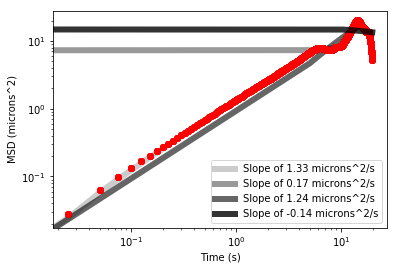

In [19]:
## Getting different diffusion coefficients for different time ranges 
## (0 to 5s, 0 to 10s, 10 to 50s, this is what sylas does)
mpld3.enable_notebook()

cutoff_start =[0,5,5,10]
cutoff_stop = [5,10,14,25]
DiffusionCoeffs = np.empty(len(cutoff_start))
AlphaValues = np.empty(len(cutoff_start))

for p in range(0, len(cutoff_start)):
    start = cutoff_start[p]
    stop = cutoff_stop[p]
   
    x = np.where(times >= start) ## returns indices
    y = np.where(times < stop) ## returns indices
    z = x[0][0]
    zz = y[0][(np.shape(y)[1]-1)]
    K = np.linspace(z,zz,zz-z+1)
    K = K.astype(int)
    
    pylab.loglog(times, msd,'ro') #Plot mean-squared displacement versus time with red filled circles
    linear_fit = np.polyfit(times[K][4:], msd[K][4:],1) #fit to polynomial of order 1 (i.e., a line)
    values_from_fit = np.polyval(linear_fit, np.hstack((np.array([0]),times[K]))) #evaluate polynomial
    pylab.loglog(np.hstack((np.array([0]),times[K])), values_from_fit,
             '-k', lw=6, alpha= .2*(p+1), label = r"Slope of %.2f microns^2/s" % linear_fit[0])
   
    print str(start)+'s to ' + str(stop) + 's'
   # print "Estimate of localization error: %.4f microns" % abs(linear_fit[1])**0.5  ##not sure what this is...is it correct?
    print "Found diffusion coeff D = %.4f (microns^2/s)" % (0.25*linear_fit[0])
    DiffusionCoeffs[p]=0.25*linear_fit[0]
    
    abc = np.where(times < stop)
    efg = np.where(times >= start)
    end = abc[0][-1]
    begin = efg[0][0]
    if (begin < 4):
        begin = 4
        logtimes = np.log(times[begin:end])
        logmsd = np.log(msd[begin:end])
        fit = np.polyfit(logtimes,logmsd,1)
        alphapower = fit[0]
        logx = fit[1]
        k= np.exp(logx)
        print "Alpha value: %.4f " % alphapower
        print "Coefficient value: %.3f " % k
    else:
        logtimes = np.log(times[begin:end])
        logmsd = np.log(msd[begin:end])
        fit = np.polyfit(logtimes,logmsd,1)
        alphapower = fit[0]
        logx = fit[1]
        k= np.exp(logx)
        print "Alpha value: %.4f " % alphapower
        print "Coefficient value: %.3f " % k
       
    AlphaValues[p]= alphapower
    print ("----------------")
pylab.legend() #puts the 'label' on the plot
pylab.xlabel('Time (s)');
pylab.ylabel('MSD (microns^2)');
   
pylab.savefig(data_directory+'\\MSDLogLogPlot.png')  

In [20]:

#Some parameters...
kb = 1.38065e-23  #Boltzmann's constant
t = 298 #temperature in Kelvin
viscosity = 1.002e-3 #8.9e-4 # 1.002 mPa*s
radius = .5e-6
diffusion_coeff = (kb*t)/(6*np.pi*viscosity*radius)*1e6*1e6
est_radius = (kb*t)/(6*np.pi*viscosity*0.25*linear_fit[0]*1e-12)
print "Theoretical D : %.10f" %diffusion_coeff
print "Estimated radius (in nanometers): %.3f nm" % (est_radius*1e9)
print "Estimated diameter (in micrometer): %.3f um" % (est_radius*1e6*2)

Theoretical D : 0.4356733673
Estimated radius (in nanometers): -6365.649 nm
Estimated diameter (in micrometer): -12.731 um


In [355]:
pickle.dump(DiffusionCoeffs, open(data_directory + '\\D.p', 'wb'))
pickle.dump(AlphaValues, open(data_directory + '\\AlphaValues.p', 'wb'))

In [194]:
.4357*2*9.5

0.8714

In [196]:
.105*.8714

0.091497

In [198]:
np.sqrt(.091497)

0.3024847103573997